In [1]:
#---- User input-----#
#--------------------#
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
# Experimental values for input
# n=2.46
# n2=1.25*10^-18 m^2/V^2
# wavelength=1.53um
# slab thickness = wavelength
# input amplitude a=1.927*10^8 V/m, time averaged
amp = np.arange(0.007*10**3,1.14*10**3,0.0707*10**3) # amplitude of source
resolution = 90
k = 4.1*10**-6 #4.1*10**-7        # Kerr susceptibility
n=2.46         # index

Using MPI version 3.1, 1 processes


In [2]:
def nl_cw(amp,resolution,k,n):
    sz = 10          # size of cell in z direction
    dpml = 1        # PML thickness
    time_set=9000         # simulation run time

    #----Continuous Source
    frq_cs=1/1.53          # meep frequency
    cs_width=100          #the inverse of the exponential rate at which the current turns off and on

    # frequency range for monitors
    nfreq = 1
    fmin = 1/1.53
    fmax = 1/1.53

    # Geometry
    d_s=1.53# slab thickness
    pos_s=0# slab position
    
    #################################################################
    # Reference simulation (source only)
    #################################################################
    geometry = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=[] ))]
    geometry2 = [mp.Block(center=mp.Vector3(0,0,pos_s),size=mp.Vector3(0,0,d_s), material=mp.Medium(index=n, chi3=k ))]

    dimensions = 1
    cell = mp.Vector3(0, 0, sz)
    pml_layers = mp.PML(dpml)
    default_material = mp.Medium(index=1, chi3=[])

    sources = mp.Source(mp.ContinuousSource(frq_cs, width=cs_width), component=mp.Ex,
                        center=mp.Vector3(0, 0, -0.5*sz + dpml), amplitude=amp)

    sim = mp.Simulation(cell_size=cell,
                        geometry=[],
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)
    trans_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    #refl_ref = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
    #                        mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))

    #         Define E field monitor
    dx=1/resolution
    dt=0.5*dx
    tm_val_x=[]
    def get_dot(sim):	
        tm_val_x.append(sim.get_array(size=mp.Vector3(), center=mp.Vector3(0,0,0), component=mp.Ex))
    #        #        #        #    
    sim.run(mp.at_every(dt,get_dot),until=time_set)
    #         plot results
    tm_val_x=np.array(tm_val_x)
    max_ind=np.size(tm_val_x)
    c=3*10**8 # m/s speed of light
    mon_t=[]
    for n in np.arange(0,max_ind,1):
        mon_tmp=(dt+dt*n)*(10**-6/c)*10**15 # s
        mon_t.append(mon_tmp)

    #         Save reference data
    freqs_ref = mp.get_flux_freqs(trans_ref)
    #plt_range_ref=1/np.asarray(freqs_ref)
    box_x1_trans_ref = mp.get_fluxes(trans_ref)
    flux_ref=np.asarray(box_x1_trans_ref)

    #################################################################
    # 1d simulation of a plane wave propagating through a linear slab
    #################################################################
    sim.reset_meep()
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml + 4)))

    sim.run(until=time_set)
    #         plot results
    freqs_lin = mp.get_flux_freqs(trans)
    plt_range_lin=1/np.asarray(freqs_lin)
    box_x1_trans_lin = mp.get_fluxes(trans)
    flux_lin=np.asarray(box_x1_trans_lin)
    box_x1_refl_lin = mp.get_fluxes(refl)
    flux_refl_lin=np.asarray(box_x1_refl_lin)

    #################################################################
    # 1d simulation of a plane wave propagating through a Kerr medium
    #################################################################
    sim.reset_meep()
    #geometry = [mp.Block(center=mp.Vector3(0,0,(sz-dpml)/4),size=mp.Vector3(0,0,(sz-dpml)/2), material=mp.Medium(index=n, chi3=k ))]
    sim = mp.Simulation(cell_size=cell,
                        geometry=geometry2,
                        sources=[sources],
                        boundary_layers=[pml_layers],
                        default_material=default_material,
                        resolution=resolution,
                        dimensions=dimensions)

    trans = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, 0.5*sz - dpml - 4)))
    refl = sim.add_flux(0.5 * (fmin + fmax), fmax - fmin, nfreq,
                            mp.FluxRegion(mp.Vector3(0, 0, -0.5*sz + dpml + 4)))

    sim.run(until=time_set)
    #         plot fluxes
    freqs = mp.get_flux_freqs(trans)
    plt_range=1/np.asarray(freqs)
    box_x1_trans = mp.get_fluxes(trans)
    flux=np.asarray(box_x1_trans)
    box_x1_refl = mp.get_fluxes(refl)
    flux_refl=np.asarray(box_x1_refl)

    E_out=np.amax(tm_val_x)/(10**-6)
    T_nl = flux/flux_ref
    R_nl = (-flux_refl+flux_ref)/flux_ref
    A_nl = 1-(-flux_refl+flux_ref)/flux_ref-flux/flux_ref
    T_l = flux_lin/flux_ref
    R_l = (-flux_refl_lin+flux_ref)/flux_ref
    A_l = 1-(-flux_refl_lin+flux_ref)/flux_ref-flux_lin/flux_ref
    print(E_out)
    print(T_nl)
    print(R_nl)
    print(A_nl)
    print(T_l)
    print(R_l)
    print(A_l)
    print(plt_range)
    return E_out, plt_range, T_nl, R_nl, A_nl, T_l, R_l, A_l

In [3]:
T_nl = np.empty(np.size(amp))
R_nl= np.empty(np.size(amp))
A_nl= np.empty(np.size(amp))
T_l= np.empty(np.size(amp))
R_l= np.empty(np.size(amp))
A_l= np.empty(np.size(amp))
E_out=np.empty(np.size(amp))
for j in range(np.size(amp)):
  print(j)
  E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j] = nl_cw(amp[j],resolution,k,n)

0
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000222921 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 388.15000000000003/9000.0 = 4.3% done in 4.0s, 88.7s to go
on time step 69953 (time=388.628), 5.71817e-05 s/step
Meep progress: 780.088888888889/9000.0 = 8.7% done in 8.0s, 84.3s to go
on time step 140508 (time=780.6), 5.67105e-05 s/step
Meep progress: 1167.3666666666668/9000.0 = 13.0% done in 12.0s, 80.5s to go
on time step 210250 (time=1168.06), 5.73548e-05 s/step
Meep progress: 1547.9555555555555/9000.0 = 17.2% done in 16.0s, 77.0s to go
on time step 278762 (time=1548.68), 5.83842e-05 s/step
Meep progress: 1939.5444444444445/9000.0 = 21.6% done in 20.0s, 72.8s to go
on time step 349264 (time=1940.36), 5.67366e-05 s/step
Meep progress: 2331.661111111111/9000.0 = 25.9% done in 24.0s, 68.6s to go
on time step 419852 (time=2332.51), 5.66672e-05 s/step
Meep progress: 2704.866666666667/9000.0 = 30.1% done in 28.0s, 65.2s to go
on time step 487034 (time=2705.74), 5.954e-05 s/step
Meep progress: 3086.516666666667/9000.0 = 34.3% done in 32.0s, 61.3s to go
on time step 555746 (

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1752.5222222222224/9000.0 = 19.5% done in 4.0s, 16.5s to go
on time step 315908 (time=1755.04), 1.26619e-05 s/step
Meep progress: 3536.727777777778/9000.0 = 39.3% done in 8.0s, 12.4s to go
on time step 637106 (time=3539.48), 1.24534e-05 s/step
Meep progress: 5256.083333333334/9000.0 = 58.4% done in 12.0s, 8.5s to go
on time step 946634 (time=5259.08), 1.29229e-05 s/step
Meep progress: 7118.8/9000.0 = 79.1% done in 16.0s, 4.2s to go
on time step 1281943 (time=7121.91), 1.19293e-05 s/step
Meep progress: 8876.427777777779/9000.0 = 98.6% done in 20.0s, 0.3s to go
on time step 1598400 (time=8880), 1.264e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000146151 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.05

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1724.2111111111112/9000.0 = 19.2% done in 4.0s, 16.9s to go
on time step 310650 (time=1725.83), 1.28762e-05 s/step
Meep progress: 3448.472222222222/9000.0 = 38.3% done in 8.0s, 12.9s to go
on time step 621066 (time=3450.37), 1.28859e-05 s/step
Meep progress: 5212.733333333334/9000.0 = 57.9% done in 12.0s, 8.7s to go
on time step 938681 (time=5214.89), 1.25939e-05 s/step
Meep progress: 6974.172222222222/9000.0 = 77.5% done in 16.0s, 4.6s to go
on time step 1255806 (time=6976.7), 1.26133e-05 s/step
Meep progress: 8679.261111111111/9000.0 = 96.4% done in 20.0s, 0.7s to go
on time step 1562750 (time=8681.94), 1.30317e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
1749961.24390103
[0.94205206]
[0.05794794]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
1
-----------
Initializing structure...
time for choose_chunkdivision = 5.72205e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216961 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 369.57222222222225/9000.0 = 4.1% done in 4.0s, 93.4s to go
on time step 66600 (time=370), 6.00601e-05 s/step
Meep progress: 726.2833333333334/9000.0 = 8.1% done in 8.0s, 91.1s to go
on time step 130813 (time=726.739), 6.22961e-05 s/step
Meep progress: 1109.8/9000.0 = 12.3% done in 12.0s, 85.3s to go
on time step 199861 (time=1110.34), 5.79309e-05 s/step
Meep progress: 1496.3722222222223/9000.0 = 16.6% done in 16.0s, 80.2s to go
on time step 269451 (time=1496.95), 5.74796e-05 s/step
Meep progress: 1863.8277777777778/9000.0 = 20.7% done in 20.0s, 76.6s to go
on time step 335606 (time=1864.48), 6.04644e-05 s/step
Meep progress: 2238.1/9000.0 = 24.9% done in 24.0s, 72.5s to go
on time step 402982 (time=2238.79), 5.93691e-05 s/step
Meep progress: 2634.222222222222/9000.0 = 29.3% done in 28.0s, 67.7s to go
on time step 474298 (time=2634.99), 5.60891e-05 s/step
Meep progress: 3029.222222222222/9000.0 = 33.7% done in 32.0s, 63.1s to go
on time step 545406 (time=3030.03), 5.62525

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1841.25/9000.0 = 20.5% done in 4.0s, 15.6s to go
on time step 331950 (time=1844.17), 1.205e-05 s/step
Meep progress: 3702.338888888889/9000.0 = 41.1% done in 8.0s, 11.4s to go
on time step 667007 (time=3705.59), 1.19383e-05 s/step
Meep progress: 5513.183333333333/9000.0 = 61.3% done in 12.0s, 7.6s to go
on time step 992987 (time=5516.59), 1.22707e-05 s/step
Meep progress: 7357.4111111111115/9000.0 = 81.7% done in 16.0s, 3.6s to go
on time step 1325003 (time=7361.13), 1.20476e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000310898 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1753.1666666666667/9000.0 = 19.5% done in 4.0s, 16.5s to go
on time step 315952 (time=1755.29), 1.26602e-05 s/step
Meep progress: 3530.077777777778/9000.0 = 39.2% done in 8.0s, 12.4s to go
on time step 635830 (time=3532.39), 1.25048e-05 s/step
Meep progress: 5252.683333333333/9000.0 = 58.4% done in 12.0s, 8.6s to go
on time step 945932 (time=5255.18), 1.2899e-05 s/step
Meep progress: 7000.322222222222/9000.0 = 77.8% done in 16.0s, 4.6s to go
on time step 1260554 (time=7003.08), 1.27137e-05 s/step
Meep progress: 8795.394444444444/9000.0 = 97.7% done in 20.0s, 0.5s to go
on time step 1583710 (time=8798.39), 1.2378e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
19424569.80730155
[0.94405557]
[0.05594443]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
2
-----------
Initializing structure...
time for choose_chunkdivision = 5.72205e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216007 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 386.7166666666667/9000.0 = 4.3% done in 4.0s, 89.1s to go
on time step 69696 (time=387.2), 5.73922e-05 s/step
Meep progress: 756.3055555555555/9000.0 = 8.4% done in 8.0s, 87.2s to go
on time step 136225 (time=756.806), 6.01248e-05 s/step
Meep progress: 1127.3666666666668/9000.0 = 12.5% done in 12.0s, 83.8s to go
on time step 203015 (time=1127.86), 5.98895e-05 s/step
Meep progress: 1515.6944444444446/9000.0 = 16.8% done in 16.0s, 79.0s to go
on time step 272936 (time=1516.31), 5.72082e-05 s/step
Meep progress: 1909.0055555555557/9000.0 = 21.2% done in 20.0s, 74.3s to go
on time step 343744 (time=1909.69), 5.64913e-05 s/step
Meep progress: 2303.0111111111114/9000.0 = 25.6% done in 24.0s, 69.8s to go
on time step 414673 (time=2303.74), 5.63951e-05 s/step
Meep progress: 2679.2555555555555/9000.0 = 29.8% done in 28.0s, 66.1s to go
on time step 482404 (time=2680.02), 5.90572e-05 s/step
Meep progress: 3061.438888888889/9000.0 = 34.0% done in 32.0s, 62.1s to go
on time step 5512

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1829.9444444444446/9000.0 = 20.3% done in 4.0s, 15.7s to go
on time step 329698 (time=1831.66), 1.21323e-05 s/step
Meep progress: 3631.527777777778/9000.0 = 40.4% done in 8.0s, 11.8s to go
on time step 654033 (time=3633.52), 1.2333e-05 s/step
Meep progress: 5457.366666666667/9000.0 = 60.6% done in 12.0s, 7.8s to go
on time step 982719 (time=5459.55), 1.21697e-05 s/step
Meep progress: 7268.6/9000.0 = 80.8% done in 16.0s, 3.8s to go
on time step 1308756 (time=7270.87), 1.22686e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000284195 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1676.8444444444444/9000.0 = 18.6% done in 4.0s, 17.5s to go
on time step 302157 (time=1678.65), 1.32382e-05 s/step
Meep progress: 3386.6277777777777/9000.0 = 37.6% done in 8.0s, 13.3s to go
on time step 609989 (time=3388.83), 1.29946e-05 s/step
Meep progress: 5166.416666666667/9000.0 = 57.4% done in 12.0s, 8.9s to go
on time step 930389 (time=5168.83), 1.24844e-05 s/step
Meep progress: 6894.25/9000.0 = 76.6% done in 16.0s, 4.9s to go
on time step 1241441 (time=6896.89), 1.28596e-05 s/step
Meep progress: 8605.172222222223/9000.0 = 95.6% done in 20.0s, 0.9s to go
on time step 1549418 (time=8607.88), 1.2988e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
37099178.37070187
[0.94929011]
[0.05070989]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
3
-----------
Initializing structure...
time for choose_chunkdivision = 6.69956e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000244856 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 374.3666666666667/9000.0 = 4.2% done in 4.0s, 92.2s to go
on time step 67458 (time=374.767), 5.92977e-05 s/step
Meep progress: 753.75/9000.0 = 8.4% done in 8.0s, 87.5s to go
on time step 135762 (time=754.233), 5.85622e-05 s/step
Meep progress: 1149.1611111111113/9000.0 = 12.8% done in 12.0s, 82.0s to go
on time step 206945 (time=1149.69), 5.61936e-05 s/step
Meep progress: 1536.5611111111111/9000.0 = 17.1% done in 16.0s, 77.7s to go
on time step 276682 (time=1537.12), 5.73594e-05 s/step
Meep progress: 1919.7166666666667/9000.0 = 21.3% done in 20.0s, 73.8s to go
on time step 345647 (time=1920.26), 5.80007e-05 s/step
Meep progress: 2304.7055555555557/9000.0 = 25.6% done in 24.0s, 69.7s to go
on time step 414968 (time=2305.38), 5.77032e-05 s/step
Meep progress: 2683.8333333333335/9000.0 = 29.8% done in 28.0s, 65.9s to go
on time step 483223 (time=2684.57), 5.8604e-05 s/step
Meep progress: 3077.8055555555557/9000.0 = 34.2% done in 32.0s, 61.6s to go
on time step 554148 (time=

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1826.0666666666668/9000.0 = 20.3% done in 4.0s, 15.7s to go
on time step 329073 (time=1828.18), 1.21554e-05 s/step
Meep progress: 3656.472222222222/9000.0 = 40.6% done in 8.0s, 11.7s to go
on time step 658579 (time=3658.77), 1.21394e-05 s/step
Meep progress: 5438.0055555555555/9000.0 = 60.4% done in 12.0s, 7.9s to go
on time step 979305 (time=5440.58), 1.24717e-05 s/step
Meep progress: 7258.933333333333/9000.0 = 80.7% done in 16.0s, 3.8s to go
on time step 1307095 (time=7261.64), 1.22029e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000258923 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1697.0166666666667/9000.0 = 18.9% done in 4.0s, 17.2s to go
on time step 305787 (time=1698.82), 1.3081e-05 s/step
Meep progress: 3481.05/9000.0 = 38.7% done in 8.0s, 12.7s to go
on time step 626974 (time=3483.19), 1.24538e-05 s/step
Meep progress: 5202.444444444444/9000.0 = 57.8% done in 12.0s, 8.8s to go
on time step 936826 (time=5204.59), 1.29096e-05 s/step
Meep progress: 6905.605555555556/9000.0 = 76.7% done in 16.0s, 4.9s to go
on time step 1243471 (time=6908.17), 1.30444e-05 s/step
Meep progress: 8641.7/9000.0 = 96.0% done in 20.0s, 0.8s to go
on time step 1556022 (time=8644.57), 1.27979e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
54773786.934102535
[0.95737218]
[0.04262782]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
4
-----------
Initializing structure...
time for choose_chunkdivision = 8.2016e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000226974 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 386.10555555555555/9000.0 = 4.3% done in 4.0s, 89.2s to go
on time step 69566 (time=386.478), 5.74999e-05 s/step
Meep progress: 746.6388888888889/9000.0 = 8.3% done in 8.0s, 88.4s to go
on time step 134470 (time=747.056), 6.16296e-05 s/step
Meep progress: 1116.0333333333333/9000.0 = 12.4% done in 12.0s, 84.8s to go
on time step 200976 (time=1116.53), 6.01454e-05 s/step
Meep progress: 1497.8333333333335/9000.0 = 16.6% done in 16.0s, 80.1s to go
on time step 269707 (time=1498.37), 5.81987e-05 s/step
Meep progress: 1883.0055555555557/9000.0 = 20.9% done in 20.0s, 75.6s to go
on time step 339056 (time=1883.64), 5.76796e-05 s/step
Meep progress: 2274.0222222222224/9000.0 = 25.3% done in 24.0s, 71.0s to go
on time step 409449 (time=2274.72), 5.68244e-05 s/step
Meep progress: 2637.7833333333333/9000.0 = 29.3% done in 28.0s, 67.5s to go
on time step 474927 (time=2638.48), 6.10903e-05 s/step
Meep progress: 3021.8944444444446/9000.0 = 33.6% done in 32.0s, 63.3s to go
on time step 

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1760.3777777777777/9000.0 = 19.6% done in 4.0s, 16.5s to go
on time step 317303 (time=1762.79), 1.26063e-05 s/step
Meep progress: 3553.05/9000.0 = 39.5% done in 8.0s, 12.3s to go
on time step 640059 (time=3555.88), 1.23933e-05 s/step
Meep progress: 5430.905555555556/9000.0 = 60.3% done in 12.0s, 7.9s to go
on time step 978117 (time=5433.98), 1.18323e-05 s/step
Meep progress: 7314.644444444445/9000.0 = 81.3% done in 16.0s, 3.7s to go
on time step 1317250 (time=7318.06), 1.17948e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.72205e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000261068 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1760.4166666666667/9000.0 = 19.6% done in 4.0s, 16.4s to go
on time step 317168 (time=1762.04), 1.26116e-05 s/step
Meep progress: 3509.8722222222223/9000.0 = 39.0% done in 8.0s, 12.5s to go
on time step 632121 (time=3511.78), 1.27003e-05 s/step
Meep progress: 5314.905555555556/9000.0 = 59.1% done in 12.0s, 8.3s to go
on time step 957088 (time=5317.16), 1.2309e-05 s/step
Meep progress: 7132.738888888889/9000.0 = 79.3% done in 16.0s, 4.2s to go
on time step 1284315 (time=7135.08), 1.22239e-05 s/step
Meep progress: 8909.133333333333/9000.0 = 99.0% done in 20.0s, 0.2s to go
on time step 1604094 (time=8911.63), 1.25086e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
72448395.49750276
[0.96743772]
[0.03256228]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
5
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216007 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 377.2555555555556/9000.0 = 4.2% done in 4.0s, 91.4s to go
on time step 67977 (time=377.65), 5.88435e-05 s/step
Meep progress: 763.5444444444445/9000.0 = 8.5% done in 8.0s, 86.3s to go
on time step 137518 (time=763.989), 5.75206e-05 s/step
Meep progress: 1159.6666666666667/9000.0 = 12.9% done in 12.0s, 81.1s to go
on time step 208832 (time=1160.18), 5.6091e-05 s/step
Meep progress: 1548.1611111111113/9000.0 = 17.2% done in 16.0s, 77.0s to go
on time step 278770 (time=1548.72), 5.71941e-05 s/step
Meep progress: 1942.4388888888889/9000.0 = 21.6% done in 20.0s, 72.7s to go
on time step 349748 (time=1943.04), 5.63557e-05 s/step
Meep progress: 2336.5722222222225/9000.0 = 26.0% done in 24.0s, 68.4s to go
on time step 420704 (time=2337.24), 5.63736e-05 s/step
Meep progress: 2739.133333333333/9000.0 = 30.4% done in 28.0s, 64.0s to go
on time step 493179 (time=2739.88), 5.51918e-05 s/step
Meep progress: 3136.5444444444447/9000.0 = 34.9% done in 32.0s, 59.8s to go
on time step 5647

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1837.7777777777778/9000.0 = 20.4% done in 4.0s, 15.6s to go
on time step 331195 (time=1839.97), 1.20775e-05 s/step
Meep progress: 3708.972222222222/9000.0 = 41.2% done in 8.0s, 11.4s to go
on time step 668035 (time=3711.31), 1.18762e-05 s/step
Meep progress: 5547.372222222222/9000.0 = 61.6% done in 12.0s, 7.5s to go
on time step 999025 (time=5550.14), 1.2085e-05 s/step
Meep progress: 7408.561111111111/9000.0 = 82.3% done in 16.0s, 3.4s to go
on time step 1334078 (time=7411.54), 1.19384e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 6.00815e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000289202 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1774.838888888889/9000.0 = 19.7% done in 4.0s, 16.3s to go
on time step 319871 (time=1777.06), 1.2505e-05 s/step
Meep progress: 3579.327777777778/9000.0 = 39.8% done in 8.0s, 12.1s to go
on time step 644719 (time=3581.77), 1.23135e-05 s/step
Meep progress: 5372.905555555556/9000.0 = 59.7% done in 12.0s, 8.1s to go
on time step 967593 (time=5375.52), 1.23887e-05 s/step
Meep progress: 7187.038888888889/9000.0 = 79.9% done in 16.0s, 4.0s to go
on time step 1294181 (time=7189.89), 1.22479e-05 s/step
Meep progress: 8984.444444444445/9000.0 = 99.8% done in 20.0s, 0.0s to go
on time step 1617765 (time=8987.58), 1.23616e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
90123004.06090337
[0.97784297]
[0.02215703]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
6
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216007 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 392.3277777777778/9000.0 = 4.4% done in 4.0s, 87.8s to go
on time step 70704 (time=392.8), 5.65745e-05 s/step
Meep progress: 787.4666666666667/9000.0 = 8.7% done in 8.0s, 83.4s to go
on time step 141836 (time=787.978), 5.6234e-05 s/step
Meep progress: 1177.6666666666667/9000.0 = 13.1% done in 12.0s, 79.7s to go
on time step 212081 (time=1178.23), 5.69443e-05 s/step
Meep progress: 1571.6444444444446/9000.0 = 17.5% done in 16.0s, 75.6s to go
on time step 283003 (time=1572.24), 5.64004e-05 s/step
Meep progress: 1972.6000000000001/9000.0 = 21.9% done in 20.0s, 71.3s to go
on time step 355188 (time=1973.27), 5.54136e-05 s/step
Meep progress: 2372.7944444444447/9000.0 = 26.4% done in 24.0s, 67.0s to go
on time step 427232 (time=2373.51), 5.5522e-05 s/step
Meep progress: 2767.5833333333335/9000.0 = 30.8% done in 28.0s, 63.1s to go
on time step 498291 (time=2768.28), 5.62914e-05 s/step
Meep progress: 3150.577777777778/9000.0 = 35.0% done in 32.0s, 59.4s to go
on time step 567241

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1830.3333333333335/9000.0 = 20.3% done in 4.0s, 15.7s to go
on time step 329806 (time=1832.26), 1.21284e-05 s/step
Meep progress: 3677.6444444444446/9000.0 = 40.9% done in 8.0s, 11.6s to go
on time step 662394 (time=3679.97), 1.20269e-05 s/step
Meep progress: 5512.772222222223/9000.0 = 61.3% done in 12.0s, 7.6s to go
on time step 992789 (time=5515.49), 1.21067e-05 s/step
Meep progress: 7334.866666666667/9000.0 = 81.5% done in 16.0s, 3.6s to go
on time step 1320792 (time=7337.73), 1.2195e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.6982e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000254869 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1742.1888888888889/9000.0 = 19.4% done in 4.0s, 16.7s to go
on time step 313892 (time=1743.84), 1.27432e-05 s/step
Meep progress: 3508.6222222222223/9000.0 = 39.0% done in 8.0s, 12.5s to go
on time step 631909 (time=3510.61), 1.25779e-05 s/step
Meep progress: 5238.927777777778/9000.0 = 58.2% done in 12.0s, 8.6s to go
on time step 943396 (time=5241.09), 1.28417e-05 s/step
Meep progress: 7019.961111111112/9000.0 = 78.0% done in 16.0s, 4.5s to go
on time step 1264056 (time=7022.53), 1.24743e-05 s/step
Meep progress: 8804.08888888889/9000.0 = 97.8% done in 20.0s, 0.4s to go
on time step 1585217 (time=8806.76), 1.24549e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
107797612.6243037
[0.98612769]
[0.01387231]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
7
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000218868 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 377.65555555555557/9000.0 = 4.2% done in 4.0s, 91.3s to go
on time step 68056 (time=378.089), 5.87752e-05 s/step
Meep progress: 740.2777777777778/9000.0 = 8.2% done in 8.0s, 89.3s to go
on time step 133339 (time=740.772), 6.12727e-05 s/step
Meep progress: 1128.8055555555557/9000.0 = 12.5% done in 12.0s, 83.7s to go
on time step 203288 (time=1129.38), 5.71849e-05 s/step
Meep progress: 1521.6666666666667/9000.0 = 16.9% done in 16.0s, 78.6s to go
on time step 274004 (time=1522.24), 5.6565e-05 s/step
Meep progress: 1904.7777777777778/9000.0 = 21.2% done in 20.0s, 74.5s to go
on time step 342978 (time=1905.43), 5.79935e-05 s/step
Meep progress: 2294.411111111111/9000.0 = 25.5% done in 24.0s, 70.1s to go
on time step 413110 (time=2295.06), 5.70358e-05 s/step
Meep progress: 2671.5055555555555/9000.0 = 29.7% done in 28.0s, 66.3s to go
on time step 481011 (time=2672.28), 5.89098e-05 s/step
Meep progress: 3058.5388888888892/9000.0 = 34.0% done in 32.0s, 62.2s to go
on time step 55

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1841.6944444444446/9000.0 = 20.5% done in 4.0s, 15.5s to go
on time step 331858 (time=1843.66), 1.20534e-05 s/step
Meep progress: 3738.6333333333337/9000.0 = 41.5% done in 8.0s, 11.3s to go
on time step 673382 (time=3741.01), 1.17127e-05 s/step
Meep progress: 5648.538888888889/9000.0 = 62.8% done in 12.0s, 7.1s to go
on time step 1017204 (time=5651.13), 1.1634e-05 s/step
Meep progress: 7541.733333333334/9000.0 = 83.8% done in 16.0s, 3.1s to go
on time step 1358034 (time=7544.63), 1.17361e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.38826e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000257969 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1781.6833333333334/9000.0 = 19.8% done in 4.0s, 16.2s to go
on time step 321191 (time=1784.39), 1.24537e-05 s/step
Meep progress: 3611.238888888889/9000.0 = 40.1% done in 8.0s, 11.9s to go
on time step 650560 (time=3614.22), 1.21444e-05 s/step
Meep progress: 5442.172222222222/9000.0 = 60.5% done in 12.0s, 7.8s to go
on time step 980158 (time=5445.32), 1.2136e-05 s/step
Meep progress: 7194.666666666667/9000.0 = 79.9% done in 16.0s, 4.0s to go
on time step 1295642 (time=7198.01), 1.26789e-05 s/step
Meep progress: 8946.605555555556/9000.0 = 99.4% done in 20.0s, 0.1s to go
on time step 1611023 (time=8950.13), 1.26831e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
125472221.18770461
[0.98978563]
[0.01021437]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
8
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216007 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 391.39444444444445/9000.0 = 4.3% done in 4.0s, 88.0s to go
on time step 70533 (time=391.85), 5.67117e-05 s/step
Meep progress: 786.6222222222223/9000.0 = 8.7% done in 8.0s, 83.5s to go
on time step 141683 (time=787.128), 5.62197e-05 s/step
Meep progress: 1176.5611111111111/9000.0 = 13.1% done in 12.0s, 79.8s to go
on time step 211878 (time=1177.1), 5.69846e-05 s/step
Meep progress: 1569.7055555555555/9000.0 = 17.4% done in 16.0s, 75.7s to go
on time step 282653 (time=1570.29), 5.65179e-05 s/step
Meep progress: 1959.0166666666667/9000.0 = 21.8% done in 20.0s, 71.9s to go
on time step 352740 (time=1959.67), 5.70724e-05 s/step
Meep progress: 2349.027777777778/9000.0 = 26.1% done in 24.0s, 68.0s to go
on time step 422951 (time=2349.73), 5.69711e-05 s/step
Meep progress: 2741.0055555555555/9000.0 = 30.5% done in 28.0s, 63.9s to go
on time step 493512 (time=2741.73), 5.66889e-05 s/step
Meep progress: 3129.25/9000.0 = 34.8% done in 32.0s, 60.0s to go
on time step 563418 (time=3

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1854.8277777777778/9000.0 = 20.6% done in 4.0s, 15.4s to go
on time step 334256 (time=1856.98), 1.19669e-05 s/step
Meep progress: 3752.9555555555557/9000.0 = 41.7% done in 8.0s, 11.2s to go
on time step 675963 (time=3755.35), 1.1706e-05 s/step
Meep progress: 5644.938888888889/9000.0 = 62.7% done in 12.0s, 7.1s to go
on time step 1016561 (time=5647.56), 1.17441e-05 s/step
Meep progress: 7556.238888888889/9000.0 = 84.0% done in 16.0s, 3.1s to go
on time step 1360651 (time=7559.17), 1.16249e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000274897 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1787.6444444444446/9000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 322034 (time=1789.08), 1.24211e-05 s/step
Meep progress: 3493.9666666666667/9000.0 = 38.8% done in 8.0s, 12.6s to go
on time step 629213 (time=3495.63), 1.30217e-05 s/step
Meep progress: 5233.7/9000.0 = 58.2% done in 12.0s, 8.6s to go
on time step 942423 (time=5235.68), 1.2771e-05 s/step
Meep progress: 6954.788888888889/9000.0 = 77.3% done in 16.0s, 4.7s to go
on time step 1252257 (time=6956.98), 1.29107e-05 s/step
Meep progress: 8744.611111111111/9000.0 = 97.2% done in 20.0s, 0.6s to go
on time step 1574471 (time=8747.06), 1.24141e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
143146829.75110483
[0.98731917]
[0.01268083]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
9
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000218153 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 386.36111111111114/9000.0 = 4.3% done in 4.0s, 89.2s to go
on time step 69621 (time=386.783), 5.74543e-05 s/step
Meep progress: 752.9/9000.0 = 8.4% done in 8.0s, 87.6s to go
on time step 135603 (time=753.35), 6.06234e-05 s/step
Meep progress: 1126.7277777777779/9000.0 = 12.5% done in 12.0s, 83.9s to go
on time step 202901 (time=1127.23), 5.94373e-05 s/step
Meep progress: 1520.3555555555556/9000.0 = 16.9% done in 16.0s, 78.7s to go
on time step 273769 (time=1520.94), 5.64434e-05 s/step
Meep progress: 1911.6944444444446/9000.0 = 21.2% done in 20.0s, 74.2s to go
on time step 344217 (time=1912.32), 5.67796e-05 s/step
Meep progress: 2309.4055555555556/9000.0 = 25.7% done in 24.0s, 69.5s to go
on time step 415817 (time=2310.09), 5.58666e-05 s/step
Meep progress: 2707.5111111111114/9000.0 = 30.1% done in 28.0s, 65.1s to go
on time step 487487 (time=2708.26), 5.58119e-05 s/step
Meep progress: 3110.666666666667/9000.0 = 34.6% done in 32.0s, 60.6s to go
on time step 560052 (time=3

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1751.5444444444445/9000.0 = 19.5% done in 4.0s, 16.6s to go
on time step 315588 (time=1753.27), 1.26748e-05 s/step
Meep progress: 3539.961111111111/9000.0 = 39.3% done in 8.0s, 12.3s to go
on time step 637575 (time=3542.08), 1.24229e-05 s/step
Meep progress: 5413.85/9000.0 = 60.2% done in 12.0s, 7.9s to go
on time step 974916 (time=5416.2), 1.18575e-05 s/step
Meep progress: 7288.283333333334/9000.0 = 81.0% done in 16.0s, 3.8s to go
on time step 1312352 (time=7290.84), 1.18541e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.4121e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262976 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1704.1944444444446/9000.0 = 18.9% done in 4.0s, 17.1s to go
on time step 307128 (time=1706.27), 1.30239e-05 s/step
Meep progress: 3482.6111111111113/9000.0 = 38.7% done in 8.0s, 12.7s to go
on time step 627297 (time=3484.98), 1.24934e-05 s/step
Meep progress: 5273.822222222222/9000.0 = 58.6% done in 12.0s, 8.5s to go
on time step 949757 (time=5276.43), 1.24047e-05 s/step
Meep progress: 7013.466666666667/9000.0 = 77.9% done in 16.0s, 4.5s to go
on time step 1262920 (time=7016.22), 1.27729e-05 s/step
Meep progress: 8709.222222222223/9000.0 = 96.8% done in 20.0s, 0.7s to go
on time step 1568185 (time=8712.14), 1.31034e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
160821438.31450528
[0.97797074]
[0.02202926]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
10
-----------
Initializing structure...
time for choose_chunkdivision = 5.88894e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000219107 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 377.65000000000003/9000.0 = 4.2% done in 4.0s, 91.3s to go
on time step 68047 (time=378.039), 5.87833e-05 s/step
Meep progress: 767.9333333333334/9000.0 = 8.5% done in 8.0s, 85.8s to go
on time step 138318 (time=768.433), 5.69234e-05 s/step
Meep progress: 1157.05/9000.0 = 12.9% done in 12.0s, 81.3s to go
on time step 208362 (time=1157.57), 5.71074e-05 s/step
Meep progress: 1525.5833333333335/9000.0 = 17.0% done in 16.0s, 78.4s to go
on time step 274707 (time=1526.15), 6.02911e-05 s/step
Meep progress: 1902.0666666666668/9000.0 = 21.1% done in 20.0s, 74.6s to go
on time step 342489 (time=1902.72), 5.90134e-05 s/step
Meep progress: 2292.75/9000.0 = 25.5% done in 24.0s, 70.2s to go
on time step 412822 (time=2293.46), 5.68734e-05 s/step
Meep progress: 2682.811111111111/9000.0 = 29.8% done in 28.0s, 65.9s to go
on time step 483050 (time=2683.61), 5.69575e-05 s/step
Meep progress: 3076.6333333333337/9000.0 = 34.2% done in 32.0s, 61.6s to go
on time step 553939 (time=3077.44), 

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1832.738888888889/9000.0 = 20.4% done in 4.0s, 15.6s to go
on time step 330309 (time=1835.05), 1.21099e-05 s/step
Meep progress: 3727.6833333333334/9000.0 = 41.4% done in 8.0s, 11.3s to go
on time step 671444 (time=3730.24), 1.17256e-05 s/step
Meep progress: 5595.405555555556/9000.0 = 62.2% done in 12.0s, 7.3s to go
on time step 1007644 (time=5598.02), 1.18977e-05 s/step
Meep progress: 7468.8/9000.0 = 83.0% done in 16.0s, 3.3s to go
on time step 1344896 (time=7471.64), 1.18606e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.38826e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000257969 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1762.0555555555557/9000.0 = 19.6% done in 4.0s, 16.4s to go
on time step 317656 (time=1764.76), 1.25923e-05 s/step
Meep progress: 3545.4944444444445/9000.0 = 39.4% done in 8.0s, 12.3s to go
on time step 638731 (time=3548.51), 1.24582e-05 s/step
Meep progress: 5337.6/9000.0 = 59.3% done in 12.0s, 8.2s to go
on time step 961350 (time=5340.83), 1.23985e-05 s/step
Meep progress: 7114.338888888889/9000.0 = 79.0% done in 16.0s, 4.2s to go
on time step 1281194 (time=7117.74), 1.25061e-05 s/step
Meep progress: 8914.027777777777/9000.0 = 99.0% done in 20.0s, 0.2s to go
on time step 1605184 (time=8917.69), 1.23461e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
178496046.87790614
[0.96108294]
[0.03891706]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
11
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216961 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 369.1166666666667/9000.0 = 4.1% done in 4.0s, 93.5s to go
on time step 66515 (time=369.528), 6.01372e-05 s/step
Meep progress: 742.8000000000001/9000.0 = 8.3% done in 8.0s, 88.9s to go
on time step 133788 (time=743.267), 5.94597e-05 s/step
Meep progress: 1115.75/9000.0 = 12.4% done in 12.0s, 84.8s to go
on time step 200929 (time=1116.27), 5.95764e-05 s/step
Meep progress: 1502.861111111111/9000.0 = 16.7% done in 16.0s, 79.8s to go
on time step 270620 (time=1503.44), 5.73969e-05 s/step
Meep progress: 1891.9444444444446/9000.0 = 21.0% done in 20.0s, 75.1s to go
on time step 340664 (time=1892.58), 5.71076e-05 s/step
Meep progress: 2278.4666666666667/9000.0 = 25.3% done in 24.0s, 70.8s to go
on time step 410249 (time=2279.16), 5.74847e-05 s/step
Meep progress: 2647.0555555555557/9000.0 = 29.4% done in 28.0s, 67.2s to go
on time step 476602 (time=2647.79), 6.02838e-05 s/step
Meep progress: 3024.438888888889/9000.0 = 33.6% done in 32.0s, 63.2s to go
on time step 544542 (time=3

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1792.7333333333333/9000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 323154 (time=1795.3), 1.2378e-05 s/step
Meep progress: 3618.8222222222225/9000.0 = 40.2% done in 8.0s, 11.9s to go
on time step 651911 (time=3621.73), 1.21671e-05 s/step
Meep progress: 5514.1611111111115/9000.0 = 61.3% done in 12.0s, 7.6s to go
on time step 993111 (time=5517.28), 1.17234e-05 s/step
Meep progress: 7388.2555555555555/9000.0 = 82.1% done in 16.0s, 3.5s to go
on time step 1330505 (time=7391.69), 1.18556e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000267982 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1709.8777777777777/9000.0 = 19.0% done in 4.0s, 17.1s to go
on time step 308173 (time=1712.07), 1.29799e-05 s/step
Meep progress: 3465.2722222222224/9000.0 = 38.5% done in 8.0s, 12.8s to go
on time step 624199 (time=3467.77), 1.26572e-05 s/step
Meep progress: 5275.85/9000.0 = 58.6% done in 12.0s, 8.5s to go
on time step 950164 (time=5278.69), 1.22713e-05 s/step
Meep progress: 7066.361111111111/9000.0 = 78.5% done in 16.0s, 4.4s to go
on time step 1272468 (time=7069.27), 1.24107e-05 s/step
Meep progress: 8789.755555555555/9000.0 = 97.7% done in 20.0s, 0.5s to go
on time step 1582723 (time=8792.91), 1.28926e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
196170655.44130635
[0.93665274]
[0.06334726]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
12
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000227928 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 374.40555555555557/9000.0 = 4.2% done in 4.0s, 92.2s to go
on time step 67479 (time=374.883), 5.92781e-05 s/step
Meep progress: 762.3444444444444/9000.0 = 8.5% done in 8.0s, 86.4s to go
on time step 137313 (time=762.85), 5.72788e-05 s/step
Meep progress: 1151.7444444444445/9000.0 = 12.8% done in 12.0s, 81.8s to go
on time step 207409 (time=1152.27), 5.70648e-05 s/step
Meep progress: 1526.55/9000.0 = 17.0% done in 16.0s, 78.3s to go
on time step 274888 (time=1527.16), 5.92783e-05 s/step
Meep progress: 1902.1166666666668/9000.0 = 21.1% done in 20.0s, 74.6s to go
on time step 342505 (time=1902.81), 5.91571e-05 s/step
Meep progress: 2286.1722222222224/9000.0 = 25.4% done in 24.0s, 70.5s to go
on time step 411641 (time=2286.89), 5.78577e-05 s/step
Meep progress: 2673.355555555556/9000.0 = 29.7% done in 28.0s, 66.3s to go
on time step 481346 (time=2674.14), 5.73863e-05 s/step
Meep progress: 3059.8611111111113/9000.0 = 34.0% done in 32.0s, 62.1s to go
on time step 550920 (time=

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1815.7166666666667/9000.0 = 20.2% done in 4.0s, 15.8s to go
on time step 327193 (time=1817.74), 1.22252e-05 s/step
Meep progress: 3660.1722222222224/9000.0 = 40.7% done in 8.0s, 11.7s to go
on time step 659276 (time=3662.64), 1.20452e-05 s/step
Meep progress: 5434.016666666666/9000.0 = 60.4% done in 12.0s, 7.9s to go
on time step 978604 (time=5436.69), 1.25263e-05 s/step
Meep progress: 7232.594444444445/9000.0 = 80.4% done in 16.0s, 3.9s to go
on time step 1302411 (time=7235.62), 1.23531e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000260115 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1719.8666666666668/9000.0 = 19.1% done in 4.0s, 16.9s to go
on time step 310082 (time=1722.68), 1.29e-05 s/step
Meep progress: 3374.927777777778/9000.0 = 37.5% done in 8.0s, 13.3s to go
on time step 607969 (time=3377.61), 1.34279e-05 s/step
Meep progress: 4984.85/9000.0 = 55.4% done in 12.0s, 9.7s to go
on time step 897859 (time=4988.11), 1.37984e-05 s/step
Meep progress: 6681.461111111112/9000.0 = 74.2% done in 16.0s, 5.6s to go
on time step 1203325 (time=6685.14), 1.30948e-05 s/step
Meep progress: 8445.15/9000.0 = 93.8% done in 20.0s, 1.3s to go
on time step 1520853 (time=8449.18), 1.25973e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
213845264.0047063
[0.90629437]
[0.09370563]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
13
-----------
Initializing structure...
time for choose_chunkdivision = 7.10487e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.00022006 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 363.52222222222224/9000.0 = 4.0% done in 4.0s, 95.0s to go
on time step 65506 (time=363.922), 6.10637e-05 s/step
Meep progress: 731.5944444444444/9000.0 = 8.1% done in 8.0s, 90.4s to go
on time step 131767 (time=732.039), 6.03678e-05 s/step
Meep progress: 1103.5444444444445/9000.0 = 12.3% done in 12.0s, 85.9s to go
on time step 198732 (time=1104.07), 5.97334e-05 s/step
Meep progress: 1491.7055555555555/9000.0 = 16.6% done in 16.0s, 80.5s to go
on time step 268614 (time=1492.3), 5.72399e-05 s/step
Meep progress: 1879.3111111111111/9000.0 = 20.9% done in 20.0s, 75.8s to go
on time step 338390 (time=1879.94), 5.73263e-05 s/step
Meep progress: 2249.9555555555557/9000.0 = 25.0% done in 24.0s, 72.0s to go
on time step 405114 (time=2250.63), 5.99491e-05 s/step
Meep progress: 2626.177777777778/9000.0 = 29.2% done in 28.0s, 68.0s to go
on time step 472842 (time=2626.9), 5.90598e-05 s/step
Meep progress: 3016.8166666666666/9000.0 = 33.5% done in 32.0s, 63.5s to go
on time step 543

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1792.5444444444445/9000.0 = 19.9% done in 4.0s, 16.1s to go
on time step 323108 (time=1795.04), 1.23798e-05 s/step
Meep progress: 3534.688888888889/9000.0 = 39.3% done in 8.0s, 12.4s to go
on time step 636716 (time=3537.31), 1.27548e-05 s/step
Meep progress: 5363.322222222222/9000.0 = 59.6% done in 12.0s, 8.1s to go
on time step 965933 (time=5366.29), 1.21501e-05 s/step
Meep progress: 7143.011111111111/9000.0 = 79.4% done in 16.0s, 4.2s to go
on time step 1286331 (time=7146.28), 1.24845e-05 s/step
Meep progress: 8913.444444444445/9000.0 = 99.0% done in 20.0s, 0.2s to go
on time step 1605071 (time=8917.06), 1.25494e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 7.41482e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagona

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1717.7111111111112/9000.0 = 19.1% done in 4.0s, 17.0s to go
on time step 309550 (time=1719.72), 1.2922e-05 s/step
Meep progress: 3483.6222222222223/9000.0 = 38.7% done in 8.0s, 12.7s to go
on time step 627454 (time=3485.86), 1.25827e-05 s/step
Meep progress: 5181.022222222223/9000.0 = 57.6% done in 12.0s, 8.8s to go
on time step 933002 (time=5183.34), 1.30914e-05 s/step
Meep progress: 6842.055555555556/9000.0 = 76.0% done in 16.0s, 5.0s to go
on time step 1232052 (time=6844.73), 1.33757e-05 s/step
Meep progress: 8556.194444444445/9000.0 = 95.1% done in 20.0s, 1.0s to go
on time step 1540646 (time=8559.14), 1.2962e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
231519872.56810638
[0.87217757]
[0.12782243]
[1.11022302e-16]
[0.94203558]
[0.05796442]
[0.]
[1.53]
14
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000216007 s
--

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 363.64444444444445/9000.0 = 4.0% done in 4.0s, 95.0s to go
on time step 65540 (time=364.111), 6.10345e-05 s/step
Meep progress: 748.0/9000.0 = 8.3% done in 8.0s, 88.3s to go
on time step 134736 (time=748.533), 5.78072e-05 s/step
Meep progress: 1103.1277777777777/9000.0 = 12.3% done in 12.0s, 85.9s to go
on time step 198662 (time=1103.68), 6.25731e-05 s/step
Meep progress: 1475.3777777777777/9000.0 = 16.4% done in 16.0s, 81.6s to go
on time step 265683 (time=1476.02), 5.96834e-05 s/step
Meep progress: 1860.7166666666667/9000.0 = 20.7% done in 20.0s, 76.7s to go
on time step 335056 (time=1861.42), 5.76605e-05 s/step
Meep progress: 2245.1833333333334/9000.0 = 24.9% done in 24.0s, 72.2s to go
on time step 404272 (time=2245.96), 5.77907e-05 s/step
Meep progress: 2615.788888888889/9000.0 = 29.1% done in 28.0s, 68.3s to go
on time step 470985 (time=2616.58), 5.9959e-05 s/step
Meep progress: 2975.516666666667/9000.0 = 33.1% done in 32.0s, 64.8s to go
on time step 535744 (time=29

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1724.5055555555557/9000.0 = 19.2% done in 4.0s, 16.9s to go
on time step 310822 (time=1726.79), 1.28691e-05 s/step
Meep progress: 3500.8333333333335/9000.0 = 38.9% done in 8.0s, 12.6s to go
on time step 630602 (time=3503.34), 1.25086e-05 s/step
Meep progress: 5277.927777777778/9000.0 = 58.6% done in 12.0s, 8.5s to go
on time step 950490 (time=5280.5), 1.25044e-05 s/step
Meep progress: 7116.083333333334/9000.0 = 79.1% done in 16.0s, 4.2s to go
on time step 1281440 (time=7119.11), 1.20864e-05 s/step
Meep progress: 8955.877777777778/9000.0 = 99.5% done in 20.0s, 0.1s to go
on time step 1612649 (time=8959.16), 1.2077e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.60284e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1644.0166666666667/9000.0 = 18.3% done in 4.0s, 17.9s to go
on time step 296405 (time=1646.69), 1.34951e-05 s/step
Meep progress: 3328.9055555555556/9000.0 = 37.0% done in 8.0s, 13.6s to go
on time step 599768 (time=3332.04), 1.31856e-05 s/step
Meep progress: 5082.727777777778/9000.0 = 56.5% done in 12.0s, 9.2s to go
on time step 915507 (time=5086.15), 1.26687e-05 s/step
Meep progress: 6860.105555555556/9000.0 = 76.2% done in 16.0s, 5.0s to go
on time step 1235476 (time=6863.76), 1.25012e-05 s/step
Meep progress: 8615.083333333334/9000.0 = 95.7% done in 20.0s, 0.9s to go
on time step 1551405 (time=8618.92), 1.26611e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
249194481.13150647
[0.8357136]
[0.1642864]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
15
-----------
Initializing structure...
time for choose_chunkdivision = 5.91278e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000221968 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 363.5888888888889/9000.0 = 4.0% done in 4.0s, 95.0s to go
on time step 65523 (time=364.017), 6.10479e-05 s/step
Meep progress: 701.088888888889/9000.0 = 7.8% done in 8.0s, 94.7s to go
on time step 126288 (time=701.6), 6.58278e-05 s/step
Meep progress: 1058.4444444444446/9000.0 = 11.8% done in 12.0s, 90.0s to go
on time step 190626 (time=1059.03), 6.21717e-05 s/step
Meep progress: 1432.9222222222222/9000.0 = 15.9% done in 16.0s, 84.5s to go
on time step 258032 (time=1433.51), 5.93425e-05 s/step
Meep progress: 1796.6000000000001/9000.0 = 20.0% done in 20.0s, 80.2s to go
on time step 323511 (time=1797.28), 6.10884e-05 s/step
Meep progress: 2174.038888888889/9000.0 = 24.2% done in 24.0s, 75.4s to go
on time step 391467 (time=2174.82), 5.88622e-05 s/step
Meep progress: 2541.7944444444447/9000.0 = 28.2% done in 28.0s, 71.1s to go
on time step 457666 (time=2542.59), 6.04242e-05 s/step
Meep progress: 2928.9555555555557/9000.0 = 32.5% done in 32.0s, 66.3s to go
on time step 52737

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1811.6333333333334/9000.0 = 20.1% done in 4.0s, 15.9s to go
on time step 326413 (time=1813.41), 1.22544e-05 s/step
Meep progress: 3634.9555555555557/9000.0 = 40.4% done in 8.0s, 11.8s to go
on time step 654668 (time=3637.04), 1.21857e-05 s/step
Meep progress: 5387.183333333333/9000.0 = 59.9% done in 12.0s, 8.0s to go
on time step 970084 (time=5389.36), 1.26817e-05 s/step
Meep progress: 7238.188888888889/9000.0 = 80.4% done in 16.0s, 3.9s to go
on time step 1303334 (time=7240.74), 1.2003e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.48363e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0516,6.0516,6.0516)
time for set_epsilon = 0.000262022 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1681.4722222222224/9000.0 = 18.7% done in 4.0s, 17.4s to go
on time step 302938 (time=1682.99), 1.3204e-05 s/step
Meep progress: 3339.2555555555555/9000.0 = 37.1% done in 8.0s, 13.6s to go
on time step 601368 (time=3340.93), 1.34036e-05 s/step
Meep progress: 5011.961111111112/9000.0 = 55.7% done in 12.0s, 9.5s to go
on time step 902547 (time=5014.15), 1.32812e-05 s/step
Meep progress: 6734.583333333334/9000.0 = 74.8% done in 16.0s, 5.4s to go
on time step 1212656 (time=6736.98), 1.28987e-05 s/step
Meep progress: 8506.388888888889/9000.0 = 94.5% done in 20.0s, 1.2s to go
on time step 1531629 (time=8509.05), 1.25403e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
266869089.69490775
[0.79805501]
[0.20194499]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]
16
-----------
Initializing structure...
time for choose_chunkdivision = 5.50747e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
time for set_epsilon = 0.000218153 s
-----------


FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 359.23333333333335/9000.0 = 4.0% done in 4.0s, 96.2s to go
on time step 64741 (time=359.672), 6.17855e-05 s/step
Meep progress: 711.9222222222222/9000.0 = 7.9% done in 8.0s, 93.1s to go
on time step 128240 (time=712.444), 6.29934e-05 s/step
Meep progress: 1087.3444444444444/9000.0 = 12.1% done in 12.0s, 87.3s to go
on time step 195822 (time=1087.9), 5.91877e-05 s/step
Meep progress: 1477.65/9000.0 = 16.4% done in 16.0s, 81.5s to go
on time step 266094 (time=1478.3), 5.69223e-05 s/step
Meep progress: 1866.9944444444445/9000.0 = 20.7% done in 20.0s, 76.4s to go
on time step 336180 (time=1867.67), 5.70728e-05 s/step
Meep progress: 2249.8944444444446/9000.0 = 25.0% done in 24.0s, 72.0s to go
on time step 405108 (time=2250.6), 5.80323e-05 s/step
Meep progress: 2615.477777777778/9000.0 = 29.1% done in 28.0s, 68.3s to go
on time step 470922 (time=2616.23), 6.07774e-05 s/step
Meep progress: 2999.1722222222224/9000.0 = 33.3% done in 32.0s, 64.0s to go
on time step 539998 (time=29

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1720.8944444444446/9000.0 = 19.1% done in 4.0s, 16.9s to go
on time step 310213 (time=1723.41), 1.28944e-05 s/step
Meep progress: 3422.0833333333335/9000.0 = 38.0% done in 8.0s, 13.0s to go
on time step 616479 (time=3424.88), 1.30606e-05 s/step
Meep progress: 5170.094444444445/9000.0 = 57.4% done in 12.0s, 8.9s to go
on time step 931176 (time=5173.2), 1.27107e-05 s/step
Meep progress: 7006.938888888889/9000.0 = 77.9% done in 16.0s, 4.6s to go
on time step 1261870 (time=7010.39), 1.20958e-05 s/step
Meep progress: 8797.927777777779/9000.0 = 97.8% done in 20.0s, 0.5s to go
on time step 1584268 (time=8801.49), 1.2407e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 5.79357e-05 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 10 with resolution 90
     block, center = (0,0,0)
          size (0,0,1.53)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal

FloatProgress(value=0.0, description='0% done ', max=9000.0)

Meep progress: 1688.4666666666667/9000.0 = 18.8% done in 4.0s, 17.3s to go
on time step 304303 (time=1690.57), 1.31449e-05 s/step
Meep progress: 3388.3833333333337/9000.0 = 37.6% done in 8.0s, 13.2s to go
on time step 610317 (time=3390.65), 1.30713e-05 s/step
Meep progress: 5150.9944444444445/9000.0 = 57.2% done in 12.0s, 9.0s to go
on time step 927658 (time=5153.66), 1.26048e-05 s/step
Meep progress: 6841.777777777778/9000.0 = 76.0% done in 16.0s, 5.0s to go
on time step 1232020 (time=6844.56), 1.31423e-05 s/step
Meep progress: 8615.255555555555/9000.0 = 95.7% done in 20.0s, 0.9s to go
on time step 1551305 (time=8618.36), 1.2528e-05 s/step
run 0 finished at t = 9000.0 (1620000 timesteps)
284543698.25830823
[0.75970765]
[0.24029235]
[0.]
[0.94203558]
[0.05796442]
[0.]
[1.53]


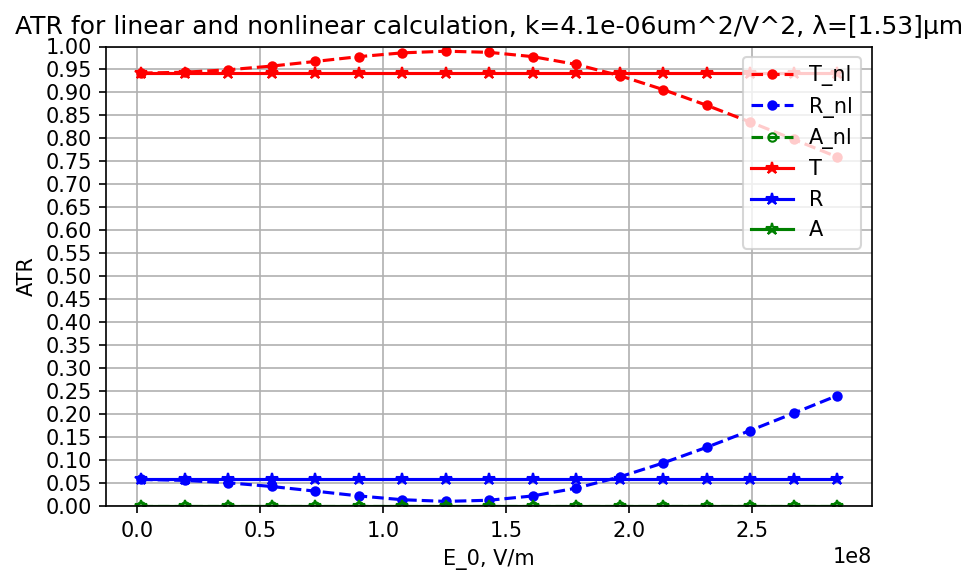

In [4]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out,T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out,R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out,A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out,T_l,'r*-',label='T')
plt.plot(E_out,R_l,'b*-',label='R')
plt.plot(E_out,A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
#plt.xticks([0.2*10**8,0.4*10**8,0.6*10**8,0.8*10**8,1*10**8,1.2*10**8,1.2*10**8,1.4*10**8,1.6*10**8,1.8*10**8,2*10**8,2.2*10**8])
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
#plt.xlim([0.1*10**8,2.4*10**8])
plt.xlabel('E_0, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_E0.txt', (E_out,T_nl,R_nl,A_nl), delimiter=',')

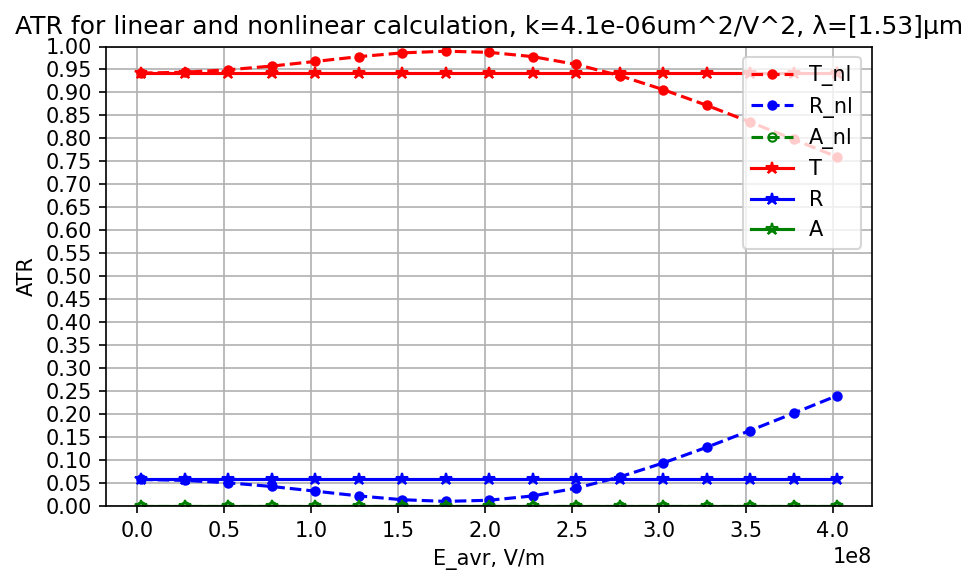

In [5]:
#         plot ATR
E_out[j], plt_range, T_nl[j], R_nl[j], A_nl[j], T_l[j], R_l[j], A_l[j]
plt.figure(dpi=150)
plt.plot(E_out*np.sqrt(2),T_nl,'ro--',label='T_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),R_nl,'bo--',label='R_nl',markersize=4)
plt.plot(E_out*np.sqrt(2),A_nl,'go--',label='A_nl',markersize=4, markerfacecolor='none')
plt.plot(E_out*np.sqrt(2),T_l,'r*-',label='T')
plt.plot(E_out*np.sqrt(2),R_l,'b*-',label='R')
plt.plot(E_out*np.sqrt(2),A_l,'g*-',label='A', markerfacecolor='none')
plt.grid(True,which="both",ls="-")
plt.yticks([-0.05,0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95, 1])
plt.xlabel('E_avr, V/m')
plt.ylabel('ATR')
plt.legend(loc='upper right')
#plt.xlim([0.85, 5])
plt.ylim([-0, 1])
plt.title('ATR for linear and nonlinear calculation, k='+str(f"{k:03}")+'um^2/V^2, λ='+str(f"{plt_range}")+'μm')
plt.tight_layout()
np.savetxt('ATR_vs_Eav.txt', (E_out*np.sqrt(2),T_nl,R_nl,A_nl), delimiter=',')